In [21]:
from utils import read_dataset, drop_useless
import matplotlib.pyplot as plt 
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import os 

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [22]:
# Reading all the data from healthy subject "Finn"
SUBJECT = "Finn"
dataset = read_dataset(SUBJECT,
                       # timestamp="10-12-24",
                       read_ort=False)

# Filling data if joint angles are not calculatable - max fill 1sec 
for nd in dataset:
    nd.fill(1.0)
# cutting data apart and leaving out if joint angle have massiv shifts -> most certainly markers are swapped
dataset = drop_useless(dataset)
# applying moving average filter on emg and joint angle data 
for nd in dataset: 
    nd.moving_average_filter(10, on="joints")

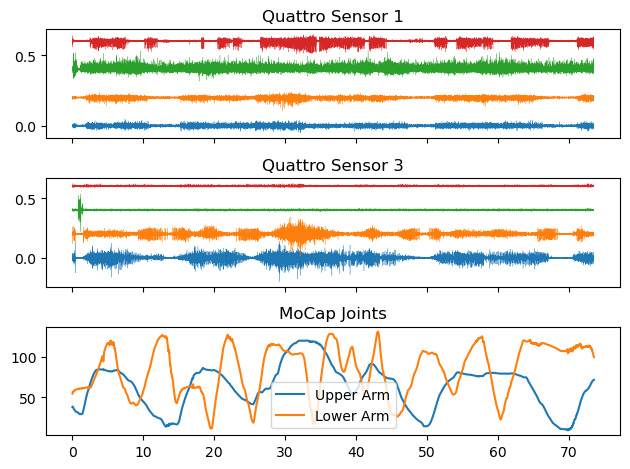

In [23]:
dataset[0].plot(plot_emg=True, plot_mocap_joints=True)

In [24]:


# shuffle dataset but keep trails as they are - this ensures test data gets from different recordings sessions

len(dataset)
shuffle_indices = np.arange(len(dataset))
np.random.seed(100)
np.random.shuffle(shuffle_indices)
dataset = [dataset[i] for i in shuffle_indices]



In [25]:


# split off test_data - will stay untouched until evaluation of models 

joints_samples = sum([data.mocap_joints.shape[0] for data in dataset])
train_indices, test_indices = [], []
x = 0
for i, data in enumerate(dataset):
    if x >= joints_samples * 0.9: 
        test_indices.append(i)
    else: 
        train_indices.append(i)
    x += data.mocap_joints.shape[0]

test_data = [dataset[i] for i in test_indices]
train_data = [dataset[i] for i in train_indices]



In [26]:
def prepare_data(data, every: int, tail_mocap: int, tail_emg: int, mocap_future: int):
    f_joints, *_, f_emg = zip(*[x.get_data(every, tail_mocap, tail_emg, mocap_future) for x in data])
    f_joints = [fj.reshape(-1, 2) for fj in f_joints]
    return f_joints, f_emg
    
# joints, emg_data = prepare_data(train_data, 10, 1, 444, 50)
# joints[1].shape, emg_data[1].shape

In [27]:
# nielsen et al. mean absolute value, zero-crossings, slope signs changes and waveform length
# https://sci-hub.ru/10.1109/icaccaf.2016.7748960

def get_feature_vector(f_emg, *features, lag=1): 
    """ Extracts features from emg data, lag needs to correspond to win size """
    if lag < 1: 
        raise ValueError(f"Lag should at least be 1, you passed {lag}")
    if not features: 
        raise ValueError("No features passed in")
    features = [(feat.lower(), None) if type(feat) == str else (feat[0].lower(), feat[1]) for feat in features]
    feat_vecs = []
    for emg in f_emg: 
        new_shape = list(emg.shape)
        new_shape[1] = int(new_shape[1] / lag)
        new_shape.insert(1, lag)
        emg = emg.reshape(*new_shape)
        fv = []
        for feat, arg in features:
            match feat: 
                case "mav": 
                    fv.append(np.mean(np.abs(emg), axis=2))
                case "rms": 
                    fv.append(np.sqrt(np.mean(emg ** 2, axis=2)))
                case "wl": 
                    fv.append(np.sum(np.abs(np.diff(emg, axis=2)), axis=2))
                case "zc": 
                    x_n = emg[..., :-1, :]
                    x_n_p1 = emg[..., 1:, :]
                    fv.append(np.count_nonzero((x_n * x_n_p1 < 0) * (np.abs(x_n - x_n_p1) > arg), axis=2))
                case "ssc": 
                    x_n = emg[..., 1:-1, :]
                    x_n_m1 = emg[..., :-2, :]
                    x_n_p1 = emg[..., 2:, :]
                    fv.append(np.count_nonzero(
                        (x_n - x_n_m1) * (x_n - x_n_p1) * ((x_n - x_n_m1) > arg) * ((x_n - x_n_p1) > arg), axis=2))
        feat_vecs.append(np.dstack(fv))
    return feat_vecs
    

In [28]:
# norm every feature, channel separatly 
from typing import Literal

def norm_emg_data(feat_vec, type_: Literal["z", "min_max"] = "min_max"): 
    """ Norms every feature and every channel """
    conc = np.vstack(feat_vec)
    if type_ == "min_max": 
        min_ = np.min(conc, axis=(0, 1))
        max_ = np.max(conc, axis=(0, 1))
        norm_vals = (min_, max_)
        feat_vec = [(fv - min_) / (max_ - min_) for fv in feat_vec]
    elif type_ == "z": 
        mu = np.mean(conc, axis=(0, 1))
        sigma = np.std(conc, axis=(0, 1))
        norm_vals = (mu, sigma)
        feat_vec = [(fv - mu) / sigma for fv in feat_vec] 
    else: 
        raise NotImplemetedError
    return feat_vec, norm_vals

In [29]:
# norm joints
def norm_joints(j): 
    conc = np.vstack(j)
    max_ = np.max(conc)
    min_ = np.min(conc)
    return [(nj - min_) / (max_ - min_) for nj in j], (min_, max_)

In [30]:
from tensorflow import keras
from keras.models import Sequential, clone_model
from keras.layers import LSTM, Dense, Dropout, Input, Flatten, LeakyReLU
from keras.optimizers import Adam

def create_model(input_shape):
    """ Creates a model using EMG-features as input, I am going to use feedforward instead of lstm here
    because depending on lag time steps are very small. One could also use 1d-cnn for lag > 1"""
    activation = LeakyReLU()
    model = Sequential() 
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(128, activation=activation))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation=activation))
    model.add(Dense(16, activation=activation))
    model.add(Dense(2, activation=activation, name="output"))
    return model


In [31]:


from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping

def train_model(m, inputs_train, inputs_val, targets_train, targets_val, *, 
                learning_rate,
                batch_size, 
                epochs, 
                path, 
                early_stop_patience: int or None = None, 
                verbose: bool = False): 
    """ trains a model based on inputs, saves training history and best model as specified by path"""
    callbacks = [ModelCheckpoint(os.path.join(path, "best_model.keras"), monitor="val_loss", save_best_only=True, mode="min"), 
                 CSVLogger(os.path.join(path, "model_history_log.csv"), append=False)]
    if early_stop_patience is not None: 
        callbacks.append(EarlyStopping(patience=early_stop_patience))
    
    optimizer = Adam(learning_rate=learning_rate)
    m.compile(optimizer=optimizer, loss="mse")
    history = m.fit(inputs_train, targets_train, batch_size=batch_size, epochs=epochs, 
                    validation_data=(inputs_val, targets_val), callbacks=callbacks, verbose=verbose)
    return history, m



In [32]:


def get_hyperparameters(parent_dir: str or os.Pathlike): 
    """ In a parent directory looks into all models and finds reads the hyperparameters trained on """
    i = 1
    hyperparamets = []
    parent_path = os.path.join("models", SUBJECT, parent_dir)
    if not os.path.exists(parent_path): 
        return []
    for model_name in os.listdir(parent_path):
        if model_name.startswith("."): 
            continue
        if not os.path.isdir(os.path.join(parent_path, model_name)): 
            continue
        try:
            params = get_params(parent_path, model_name)
        except FileNotFoundError: 
            continue
        hyperparamets.append(params)
    return hyperparamets

def get_params(parent_path, model_name) -> dict:
    with open(os.path.join(parent_path, model_name, "info.txt")) as file:
        params = {}
        for line in file.readlines(): 
            if line == "\n": 
                break
            key, val = line.split(":")
            key = key.strip()
            val = eval(val)
            params[key] = val
    return params



In [33]:


def get_directory(parent_dir: str or os.Pathlike): 
    """ In a parent directory finds next free dir and creates it """
    i = 1
    while True: 
        path = os.path.join("models", SUBJECT, parent_dir, f"model{i:03}")
        if not os.path.exists(path):
            os.makedirs(path)
            break
        i += 1
    return path

def write_info(path, norm_vals, norm_vals_targets, **info): 
    """ save everything needed for reproduction """
    with open(os.path.join(path, "info.txt"), "w+") as file:
        for key, val in info.items(): 
            file.write(f"{key} : {val} \n")
        file.write("\n")
        file.write(f"min_joints: {norm_vals_targets[0]}\n")
        file.write(f"max_joints: {norm_vals_targets[1]}\n")
        for vals in norm_vals: 
            file.write("\n")
            np.savetxt(file, vals)
            file.write("\n")



In [34]:
# grid search base on: lag, features_combination, batch_size, learning rate
# mean absolute value, zero-crossings, slope signs changes and waveform length
import os 
from itertools import product


def grid_search_feat_extr(): 
    """ Preform a grid search. Different Parameters are tuned """ 
    lags = (1, 3, 5)
    feat_sets = (
        ("rms", ("zc", 3e-3), ("ssc", 3e-4)), 
        ("rms", ), 
        ("mav", ("ssc", 3e-4)), 
        ("mav", ("zc", 3e-3), ("ssc", 3e-4), "wl")
    )
    lrs = (1e-4, 8e-5)
    btch_sizes = (32, 128)

    for lag, features, learning_rate, batch_size in product(lags, feat_sets, lrs, btch_sizes): 
        parameter_set = {"lag": lag, "features": features, "learning_rate": learning_rate, "batch_size": batch_size}
        if any(parameter_set == params for params in get_hyperparameters("feat_ex_models")): 
            print("hyperparameter set already exists")
            continue
        path = get_directory("feat_ex_models")
        print(f"model at {path} with lag: {lag}, features: {features}, learing_rate: {learning_rate}, batch_size: {batch_size}")
        
        # get feature vector and norm data
        targets, inputs = prepare_data(train_data, 10, 1, 222 * lag, 5)
        
        inputs = get_feature_vector(inputs, *features, lag=lag)
        inputs, norm_vals = norm_emg_data(inputs, "z")
        targets, norm_vals_targets = norm_joints(targets)

        write_info(path, norm_vals, norm_vals_targets, **parameter_set)
        
        # prepare inputs and targets: shuffle data - split off validation set 
        
        inputs = np.vstack(inputs)
        targets = np.vstack(targets)
        shuf_ind = np.arange(inputs.shape[0])
        np.random.seed(5)
        np.random.shuffle(shuf_ind)
    
        inputs = inputs[shuf_ind]
        targets = targets[shuf_ind]
        
        inputs_train, inputs_val = np.split(inputs, (int(inputs.shape[0] * 0.85), ))
        targets_train, targets_val = np.split(targets, (int(targets.shape[0] * 0.85), ))
        
        # train the model
        
        m = create_model((lag, len(features) * 8))
        train_model(m, inputs_train, inputs_val, targets_train, targets_val, 
                    learning_rate=learning_rate, 
                    batch_size=batch_size, 
                    path=path, 
                    epochs=1000, 
                    early_stop_patience=50)
        

grid_search_feat_extr()

hyperparameter set already exists
hyperparameter set already exists
hyperparameter set already exists
hyperparameter set already exists
hyperparameter set already exists
hyperparameter set already exists
hyperparameter set already exists
hyperparameter set already exists
hyperparameter set already exists
hyperparameter set already exists
hyperparameter set already exists
hyperparameter set already exists
hyperparameter set already exists
hyperparameter set already exists
hyperparameter set already exists
hyperparameter set already exists
hyperparameter set already exists
hyperparameter set already exists
hyperparameter set already exists
hyperparameter set already exists
hyperparameter set already exists
hyperparameter set already exists
hyperparameter set already exists
hyperparameter set already exists
hyperparameter set already exists
hyperparameter set already exists
hyperparameter set already exists
hyperparameter set already exists
hyperparameter set already exists
hyperparameter

In [35]:
from typing import Sequence
from scipy.signal import resample_poly
from scipy.ndimage import uniform_filter1d

def emg_filter_downsample(f_emg: Sequence[np.ndarray], filter_time: float, downsample_factor: float = 1.0): 
    """ Downsamples the EMG signal as sample rate is very high, applies rectification and moving average filter """
    filter_period = round(2222e-3 * filter_time / downsample_factor)
    if downsample_factor < 1: 
        raise ValueError("Downsample factor needs to be greater or equal 1")
    data = []
    for emg in f_emg: 
        x = resample_poly(emg, 1, downsample_factor, axis=1)
        x = uniform_filter1d(np.abs(x), size=filter_period, axis=1)
        data.append(x)
    return data
        

In [36]:
from typing import Tuple

def create_direct_model(lstm_layer: Tuple[int, int], input_shape: Tuple[int, int]): 
    """ Creates a model with lstm layer to directly extract features from EMG signal """ 
    activation = LeakyReLU() # because EMG signal might be z-score normed
    # activation = "relu"
    model = Sequential()
    model.add(Input(input_shape))
    model.add(LSTM(lstm_layer[0], return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(lstm_layer[1]))
    model.add(Dense(32, activation=activation))
    model.add(Dense(8,  activation=activation))
    model.add(Dense(2, activation=activation))
    return model 

In [37]:
def grid_search_direct_model():
    """ Preforms a grid search with direct (meaning features are extracted direclty from rectified, moving ave. filtered emg-signal) models"""
    lags = (1, 3, 
            #5
           )
    f_times = (20, 50)
    down_facs = (1, 3, 5)
    btch_sizes = (32, 128) 
    l_rates = (8e-5, ) 
    lstm_layers = ((64, 32), ) # , (128, 64))

    for lag, down_fac, f_time, batch_size, learning_rate, lstm in product(lags, down_facs, f_times, btch_sizes, l_rates, lstm_layers): 
        
        parameter_set = {"lag": lag, 
                         "downsample_factor": down_fac, 
                         "filter_time": f_time, 
                         "lstm_layers": lstm, 
                         "learning_rate": learning_rate, 
                         "batch_size": batch_size}
        if any(parameter_set == params for params in get_hyperparameters("direct_models")): 
            print("hyperparameter set already exists")
            continue
            
        path = get_directory("direct_models")
        print(f"model at {path} lag: {lag}, downsampling_factor: {down_fac}, filter_time: {f_time} ms", 
              f"batch_size: {batch_size}, learning_rate: {learning_rate}, lstm_layers: {lstm}")

        # get data
        targets, inputs = prepare_data(train_data, 10, 1, lag * 222, 5)
        targets, norm_vals_targets = norm_joints(targets)
        inputs = emg_filter_downsample(inputs, f_time, down_fac)
        inputs, norm_vals = norm_emg_data(inputs, "z")
        # inputs, norm_vals = dummy_norm(inputs)

        write_info(path, norm_vals, norm_vals_targets, **parameter_set)

        # shuffle data and split of validation data 
        inputs = np.vstack(inputs)
        targets = np.vstack(targets)
        shuffle_indices = np.arange(inputs.shape[0])
        np.random.seed(100)
        np.random.shuffle(shuffle_indices) 
        inputs = inputs[shuffle_indices]
        targets = targets[shuffle_indices]
        split = (int(inputs.shape[0] * 0.85), )
        inputs_train, inputs_val = np.split(inputs, split)
        targets_train, targets_val = np.split(targets, split)

        # create and train model 
        m = create_direct_model(lstm, inputs_train.shape[1:])
        train_model(m, inputs_train, inputs_val, targets_train, targets_val, 
                    learning_rate=learning_rate, 
                    batch_size=batch_size, 
                    path=path, 
                    epochs=1000, 
                    early_stop_patience=50)


grid_search_direct_model()


hyperparameter set already exists
hyperparameter set already exists
hyperparameter set already exists
hyperparameter set already exists
hyperparameter set already exists
hyperparameter set already exists
hyperparameter set already exists
hyperparameter set already exists
hyperparameter set already exists
hyperparameter set already exists
hyperparameter set already exists
hyperparameter set already exists
hyperparameter set already exists
hyperparameter set already exists
hyperparameter set already exists
hyperparameter set already exists
hyperparameter set already exists
hyperparameter set already exists
hyperparameter set already exists
hyperparameter set already exists
hyperparameter set already exists
hyperparameter set already exists
hyperparameter set already exists
hyperparameter set already exists


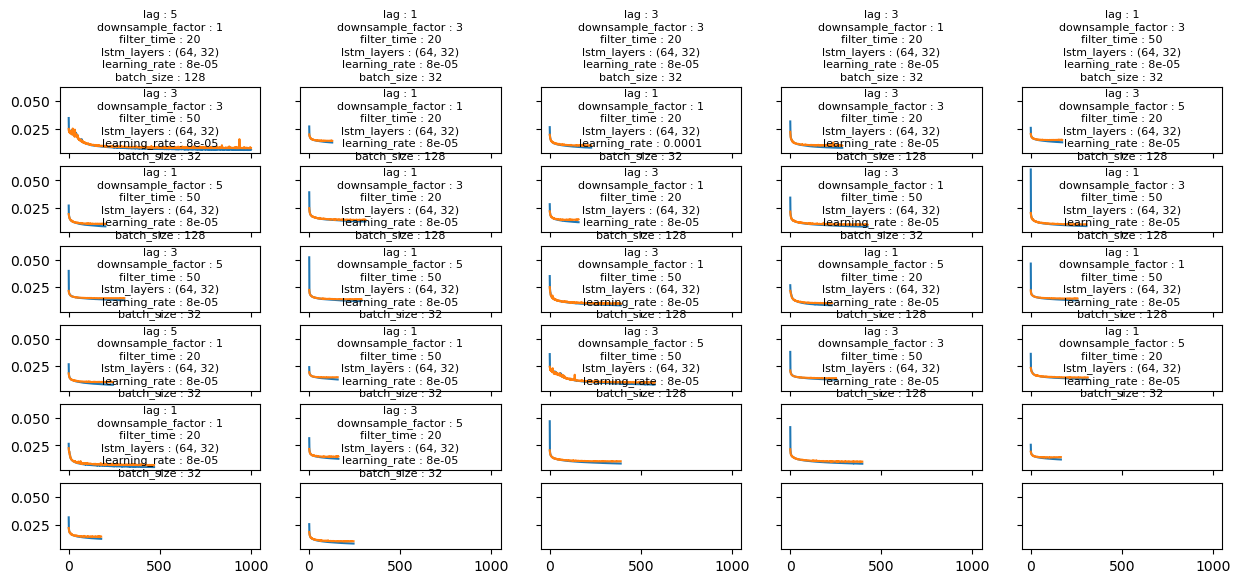

In [38]:
def plot_history(*parent_dir: str or os.Pathlike): 
    """ Plots the train history of all models saved in the parent dir """
    if not parent_dir: 
        raise ValueError("Please insert parent dir param")
    history = []
    param_sets = []
    for dir_ in parent_dir: 
        parent_path = os.path.join("models", SUBJECT, dir_)
        # param_sets += get_hyperparameters(dir_)
        for name in os.listdir(parent_path): 
            if name.startswith("."): 
                continue
            if not os.path.isdir(os.path.join(parent_path, name)): 
                continue
            param_sets.append(get_params(parent_path, name))
            history.append(np.genfromtxt(os.path.join(parent_path, name, "model_history_log.csv"), delimiter=","))
    rows = np.sqrt(len(history))
    rows, rem = int(rows // 1), rows % 1
    cols = rows
    if rem: 
        rows += 1
    if rem >= 0.5:
        cols += 1
    fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, squeeze=False, figsize=(15, 6))
    for ax, hist, params in zip(axs.flatten(), history, param_sets): 
        ax.plot(hist[:, 1:])
        title = ""
        for i, (key, val) in enumerate(params.items()): 
            title += f"{key} : {val}"
            if i != len(params) - 1: 
                title += "\n"
        ax.set_title(title, fontsize=8)


plot_history("direct_models")
 #plt.tight_layout()

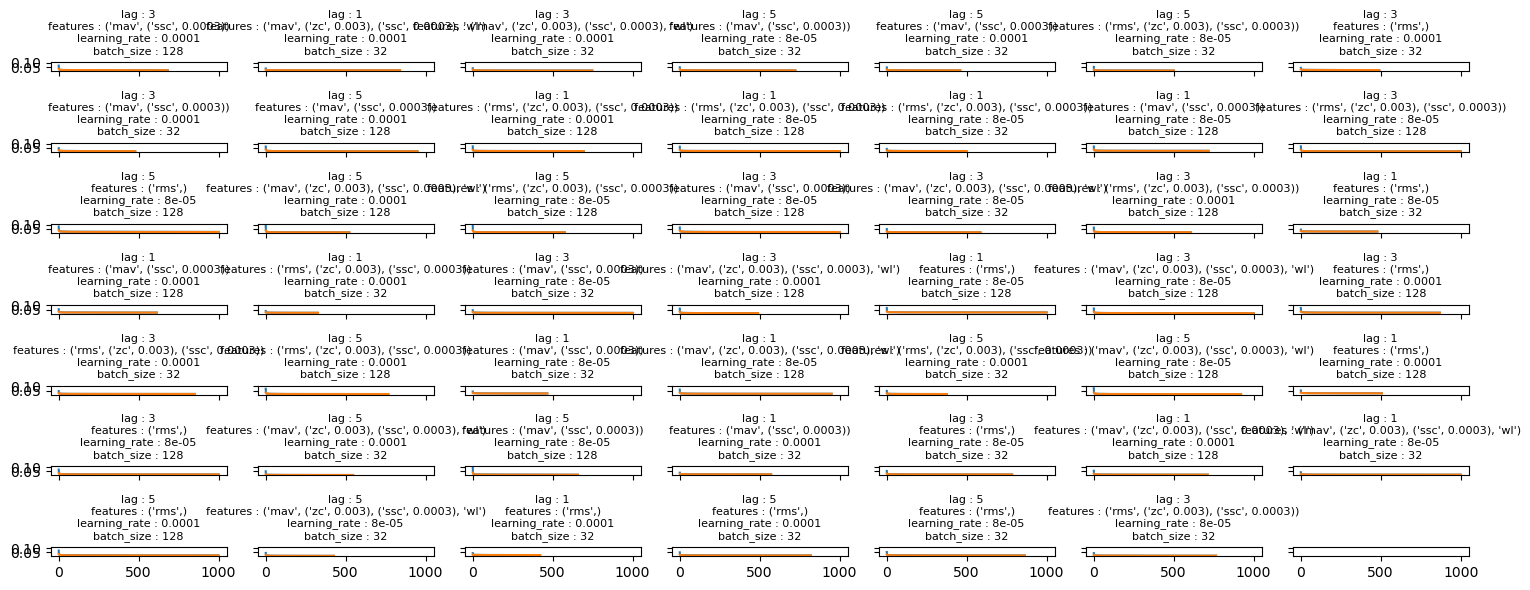

In [39]:
plot_history("feat_ex_models")
plt.tight_layout()


In [69]:
# from keras.models import load_model
from tensorflow.keras.saving import load_model

def read_norm_vals(path): 
    """ Reads norm values needed to scale emg signals/features and reverse scale of predicted joints to degrees """
    path = os.path.join(path, "info.txt")
    count = 0
    with open(path, "r") as file: 
        x = []
        for line in file.readlines(): 
            if line == "\n" and x: 
                yield x
                x = []
                continue
            if line.strip(): 
                x.append(line.strip())

def predict(parent_dir): 
    """ Predicts based on test emg-data return predictions and targets in degrees """
    # hyper_params = get_hyperparameters(parent_dir)
    parent_path = os.path.join("models", SUBJECT, parent_dir)
    predictions, targets, parameters = [], [], []
    for name in os.listdir(parent_path):
        if name.startswith("."): 
            continue
        params = get_params(parent_path, name)
        parameters.append(params)
        trgs, inputs = prepare_data(test_data, 10, 1, params["lag"] * 222, 5)
        if parent_dir == "direct_models": 
            inputs = emg_filter_downsample(inputs, params["filter_time"], params["downsample_factor"])
        elif parent_dir == "feat_ex_models": 
            inputs = get_feature_vector(inputs, *params["features"], lag=params["lag"])
        _, scale_joints, *emg_scale = read_norm_vals(os.path.join(parent_path, name))
        mu, sigma = np.array(emg_scale[0], dtype=float), np.array(emg_scale[1], dtype=float)
        scale_joints = {key: float(val) for scale in scale_joints for key, val in [scale.split(":")]}
        inputs = [(input_ - mu) / sigma for input_ in inputs]
        model = load_model(os.path.join(parent_path, name, "best_model.keras"), custom_objects={"LeakyReLU": LeakyReLU})
        preds = [model.predict(input_, verbose=False) for input_ in inputs]
        preds = [pred * (scale_joints["max_joints"] - scale_joints["min_joints"]) + scale_joints["min_joints"] for pred in preds]
        # trgs = [(tar - scale_joints["min_joints"]) / (scale_joints["max_joints"] - scale_joints["min_joints"]) for tar in trgs]
        predictions.append(preds)
        targets.append(trgs)
    return parameters, predictions, targets

feat_params, pred_feat, targets_feat = predict("feat_ex_models")

In [72]:
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd 

def print_metrics(parameters, pred, targets):
    """ Prints the results of the grid search - and model results (r^2 of flexion/extension; 
    r^2 of pronation supination and mean squared error in degrees"""
    # parent_path = os.path.join("models", SUBJECT, parent_dir)
    results = []
    for prds, trgts, parms in zip(pred, targets, parameters):
        prds = np.vstack(prds)
        trgts = np.vstack(trgts)
        res = parms
        res["r2_flex_ext"] = r2_score(trgts[:, 0], prds[:, 0])
        res["r2_pro_sup"] = r2_score(trgts[:, 1], prds[:, 1])
        res["r2"] = r2_score(trgts, prds)
        res["mse"] = mean_squared_error(trgts, prds)
        results.append(res)
    return pd.DataFrame(results)

print_metrics(feat_params, pred_feat, targets_feat)

,lag,features,learning_rate,batch_size,r2_flex_ext,r2_pro_sup,r2,mse
0,3,"(mav, (ssc, 0.0003))",0.00010,128,-0.270482,-0.057289,-0.163885,1596.864136
1,1,"(mav, (zc, 0.003), (ssc, 0.0003), wl)",0.00010,32,-0.872553,-0.495537,-0.684043,2297.071777
2,3,"(mav, (zc, 0.003), (ssc, 0.0003), wl)",0.00010,32,-0.816981,-0.049404,-0.433191,1883.698853
3,5,"(mav, (ssc, 0.0003))",0.00008,32,-0.322877,-0.274068,-0.298472,1813.681763
4,5,"(mav, (ssc, 0.0003))",0.00010,32,-0.429732,-0.228693,-0.329214,1832.003418
5,5,"(rms, (zc, 0.003), (ssc, 0.0003))",0.00008,32,-0.478488,-0.374466,-0.426477,1984.263916
6,3,"(rms,)",0.00010,32,-0.841980,-0.405560,-0.623773,2205.090820
7,3,"(mav, (ssc, 0.0003))",0.00010,32,-0.256492,-0.706716,-0.481608,2150.883301
8,5,"(mav, (ssc, 0.0003))",0.00010,128,-0.581836,-0.006935,-0.294385,1722.220703
9,1,"(rms, (zc, 0.003), (ssc, 0.0003))",0.00010,128,-0.139228,-0.505358,-0.322294,1912.507568


In [73]:
dir_params, pred_dir, targets_dir = predict("direct_models")
print_metrics(dir_params, pred_dir, targets_dir)



,lag,downsample_factor,filter_time,lstm_layers,learning_rate,batch_size,r2_flex_ext,r2_pro_sup,r2,mse
0,5,1,20,"(64, 32)",0.00008,128,-0.418236,-1.272102,-0.845171,2727.742676
1,1,3,20,"(64, 32)",0.00008,32,-0.822126,-0.666005,-0.744066,2417.470703
2,3,3,20,"(64, 32)",0.00008,32,-0.872448,-0.676947,-0.774696,2456.112061
3,3,1,20,"(64, 32)",0.00008,32,-0.658575,-0.494438,-0.576502,2183.378174
4,1,3,50,"(64, 32)",0.00008,32,-0.892211,-0.868694,-0.880455,2630.332031
5,3,3,50,"(64, 32)",0.00008,32,-1.316510,-0.787756,-1.052132,2790.535156
6,1,1,20,"(64, 32)",0.00008,128,-0.176082,-0.224526,-0.200304,1689.386841
7,1,1,20,"(64, 32)",0.00010,32,-0.614366,-0.660101,-0.637234,2301.004883
8,3,3,20,"(64, 32)",0.00008,128,-0.775855,-0.710501,-0.743182,2433.228027
9,3,5,20,"(64, 32)",0.00008,128,-0.682586,-0.930628,-0.806609,2573.441895


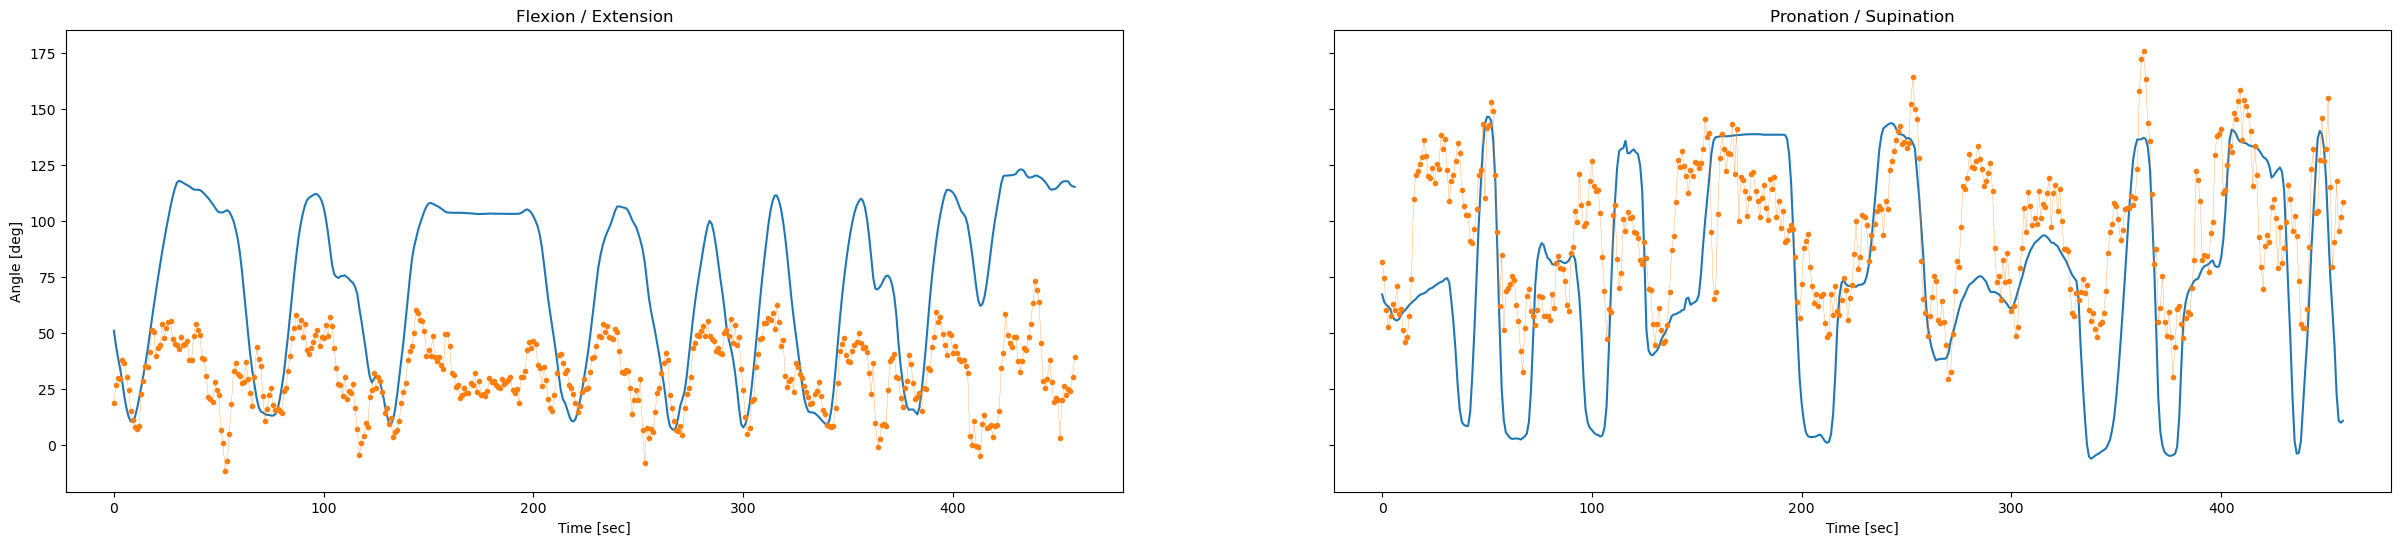

In [43]:
# Plot the results of a single test-data trail of the best feat extraction model - blue targets / orange predictions 
i, j = 0, 20
fig, axs = plt.subplots(1, 2, figsize=(30, 6), sharey=True)
axs[0].set_title("Flexion / Extension")
axs[1].set_title("Pronation / Supination")
axs[0].set_ylabel("Angle [deg]")
axs[0].set_xlabel("Time [sec]")
axs[1].set_xlabel("Time [sec]")
for k, ax in enumerate(axs.flatten()): 
    ax.plot(targets_feat[i][j][:, k])
    ax.plot(pred_feat[i][j][:, k], marker="o", markersize=3, lw=.2)

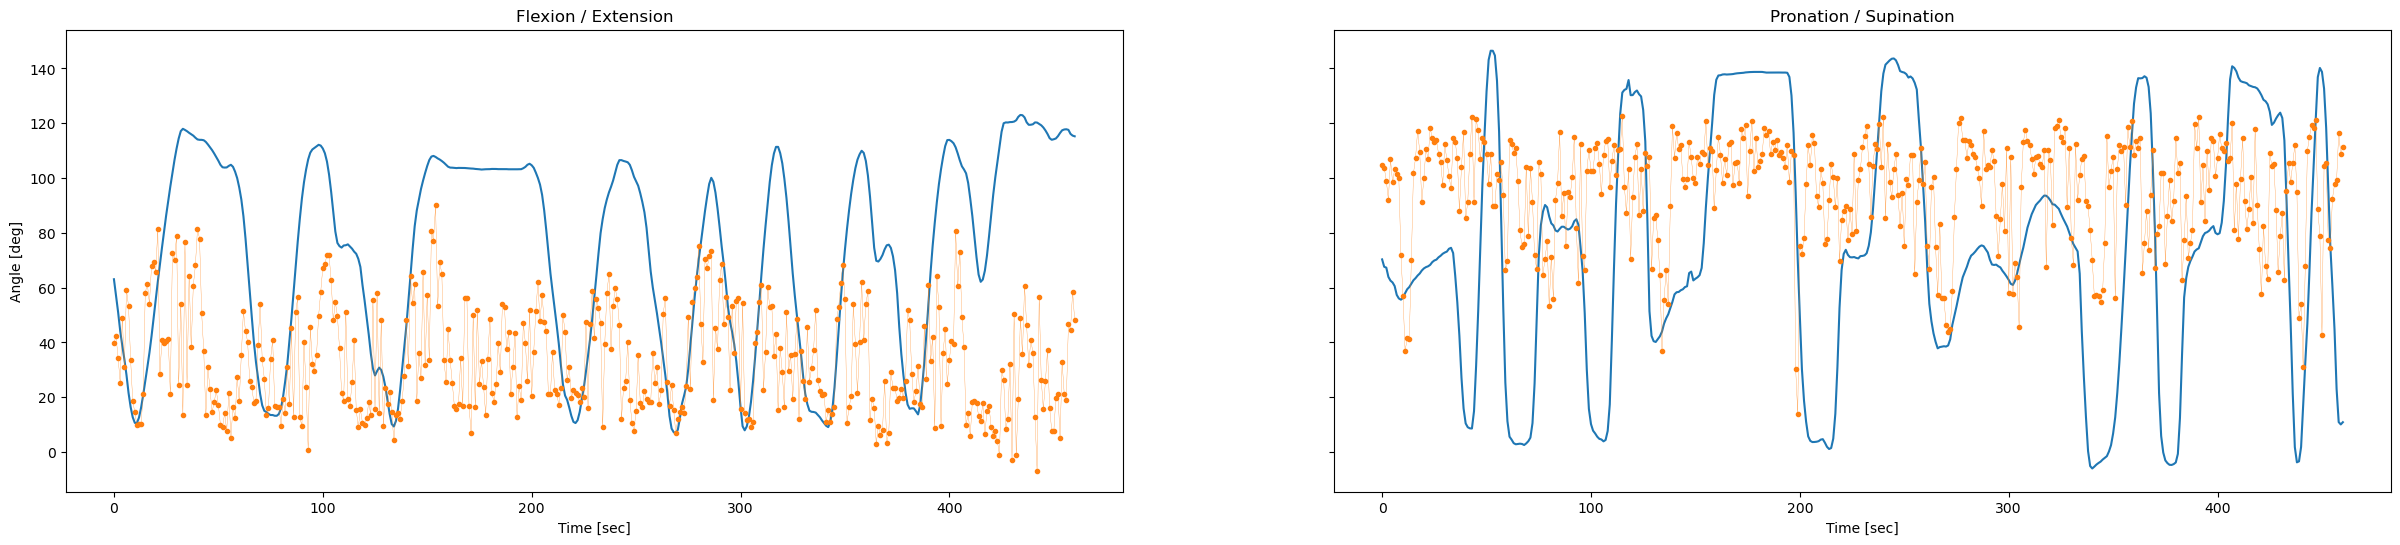

In [44]:
# same for the direct models 
i, j = 1, 20
fig, axs = plt.subplots(1, 2, figsize=(30, 6), sharey=True)
axs[0].set_title("Flexion / Extension")
axs[1].set_title("Pronation / Supination")
axs[0].set_ylabel("Angle [deg]")
axs[0].set_xlabel("Time [sec]")
axs[1].set_xlabel("Time [sec]")
for k, ax in enumerate(axs.flatten()): 
    ax.plot(targets_dir[i][j][:, k])
    ax.plot(pred_dir[i][j][:, k], marker="o", markersize=3, lw=.2)

In [45]:
def prepare_data_narx(n: int, inputs, targets, lstm_ready: bool=False): 
    """ Prepares the data: Adds <n> previous joints to output """
    # joints = data[0][:, -1, :]
    past = sliding_window_view(targets, (n, 2))
    if lstm_ready: 
        past = past.reshape(-1, n, 2)
    else: 
        past = past.reshape(-1, n*2)
    return inputs[n:], targets[n:], past[:-1]

In [46]:
# Different to teacher forcing, schedulded sampleing forces the model to train on its own predictions 
# this is more realistic in real application as there is no "teacher" presenting former "correct" predictions 
# to train the model we are starting of with teacher forcing, e.g. presenting actual measured positions (warm-up phase)
# and by time more and more model predictions will be inputted into the model 

import tensorflow as tf 
import time 
import json 
import pickle 
from typing import Literal
from collections import namedtuple

Info = namedtuple("Info", "lengths shuf_idx unshuf_idx")


class ScheduledSamplingTrainer: 

    def __init__(self, m, t_data, v_data, n_past_joints, learning_rate: float = 5e-4, clipvalue=None, batch_size:int =32, *args, **kwargs): 
        self.optimizer = Adam(learning_rate=learning_rate, clipvalue=clipvalue)
        self.train_metric = keras.metrics.MeanSquaredError()
        self.val_metric = keras.metrics.MeanSquaredError()
        self.model = m
        self._batch_size = batch_size
        self._val_data = self._prepare_data(v_data, self._get_shuffle_info(v_data))
        self._train_shuf_info = self._get_shuffle_info(t_data)
        self._train_data = self._prepare_data(t_data, self._train_shuf_info)
        self._n_prev = n_past_joints
        
    def _prepare_data(self, data, info: Info): 
        """ Shuffles data and prepares batches for training """
        data = [np.vstack(x) for x in zip(*data)]
        res = []
        for set_ in data: 
            set_[:] = set_[info.shuf_idx]
            split = data[0].shape[0] % self._batch_size 
            full, remainder = np.split(set_, (-split, ))
            res.append(list(set_[:-split].reshape(-1, 32, *set_.shape[1:])) + [remainder])            
        return list(zip(*res))

    @staticmethod
    def _unshuffle_data(data, info: Info):
        """ Reverses the _prepare_data method. Needed for scheduled sampling """
        res = []
        for d in zip(*data): 
            d = np.vstack(d)
            d = d[info.unshuf_idx]
            res.append(np.split(d, info.lengths))
        return list(zip(*res))
        
    @staticmethod
    def _get_shuffle_info(data):
        """ Returns information on how to shuffle and reverse shuffle """
        data, *_ = zip(*data)
        lengths = [x.shape[0] for x in data]
        indices = np.arange(sum(lengths))
        np.random.seed(5)
        np.random.shuffle(indices)
        unshuf_indices = np.zeros_like(indices)
        unshuf_indices[indices] = np.arange(sum(lengths))
        return Info(np.cumsum(lengths[:-1]), indices, unshuf_indices)
        
    @tf.function
    def train_step(self, x, y): 
        with tf.GradientTape() as tape:
            logits = self.model(x, training=True)
            loss_value = keras.losses.MeanSquaredError()(y, logits)
        grads = tape.gradient(loss_value, self.model.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
        self.train_metric.update_state(y, logits)
        return logits
    
    @tf.function
    def val_step(self, x, y): 
        logits = self.model(x, training=False)
        self.val_metric.update_state(y, logits)

    def _generate_new(self, samples): 
        """ This method unshuffles (train) data, makes new past_joints_train list (first <n_prev> values are kept) based on random sampling and shuffles back """
        updated_past_joints = []
        for sampled_data, past_joints_prev in self._unshuffle_data(samples, self._train_shuf_info): 
            past = sliding_window_view(sampled_data, (self._n_prev, 2))
            # past = past.reshape(-1, n_prev, 2) # this is if past joint model uses lstm architecture
            past = past.reshape(-1, self._n_prev * 2)
            updated_past_joints.append([np.vstack((past_joints_prev[:self._n_prev], past[:-1]))])
        return [x[0] for x in self._prepare_data(updated_past_joints, self._train_shuf_info)]

    @staticmethod
    def _linear_decay(epochs, warm_up=0): 
        for i in range(warm_up): 
            yield 1
        for epoch in range(epochs - warm_up): 
            yield 1 - epoch / (epochs - 1) 
            
    def train_loop(self, epochs, warm_up=0, *args, **kwargs):
        """ Trains the model: as epsilon counts down more and more model predictions will be inputted """
        history = []
        decay_fn = self._linear_decay(epochs, warm_up)
        _, past_joints_train, _ = zip(*self._train_data)
        for epoch, epsilon in enumerate(decay_fn, start=1): 
            start_time = time.time()
            samples = []
            for i, (emg_batch, _, y_batch) in enumerate(self._train_data): 
                pred = self.train_step((emg_batch, past_joints_train[i]), y_batch)
                pred = np.where(pred < 0, 0, pred)
                pred = np.where(pred > 1, 1, pred)
                sampler = np.where(np.random.random(pred.shape) < epsilon, y_batch, pred)
                samples.append((sampler, past_joints_train[i]))
            
            past_joints_train = self._generate_new(samples)
                
            for emg_val, past_joints_val, y_val in self._val_data: 
                self.val_step((emg_val, past_joints_val), y_val)
            history.append((self.train_metric.result().numpy(), self.val_metric.result().numpy()))
            print(
                (f"Epoch {(epoch):4} / {epochs} \t taking {round(time.time() - start_time):5} sec"
                f"\t loss: {self.train_metric.result():.4f} \t val_loss {self.val_metric.result():.4f}"))
            self.train_metric.reset_state()
            self.val_metric.reset_state()
        return history

In [47]:
from keras.layers import concatenate
from keras.models import Model
import inspect



def create_past_joints_model(input_shape): 
    activation = "relu"
    model = Sequential()
    model.add(Input(input_shape))
    model.add(Dense(6, activation=activation))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation=activation))
    return model 


def concatenate_models(model1, model2): 
    input1 = Input(shape=model1.input_shape[1:])
    output1 = model1(input1)

    input2 = Input(shape=model2.input_shape[1:])
    output2 = model2(input2)
    
    merged = concatenate([output1, output2])
    layer = Dense(8, activation=LeakyReLU())(merged)
    layer = Dense(4, activation=LeakyReLU())(layer)
    final_output = Dense(2, activation=LeakyReLU())(layer)

    return Model(inputs=[input1, input2], outputs=final_output)


def train_narx(use_direct_model: bool, 
               use_teacher_forcing: bool, 
               *,
               lag: int, 
               epochs: int, 
               n_past_joints: int, 
               learning_rate: float, 
               batch_size: int, 
               **kwargs): 
    args = locals()
    kw = args.pop("kwargs")

    args_dict = {**args, **kw}
    print(args_dict)
    
    if any(args_dict == params for params in get_hyperparameters("narx")): 
        print("hyperparameter set already exists")
        return 
    
    path = get_directory("narx")
    targets, emg_data = prepare_data(train_data, 10, 1, 222 * lag, 5)

    if use_direct_model: 
        emg_data = emg_filter_downsample(emg_data, kwargs["filter_time"], kwargs["downsample_factor"])
        emg_shape = (222 * lag, 8)
    else: 
        emg_data = get_feature_vector(emg_data, *kwargs["features"], lag=lag)
        emg_shape = (lag, len(kwargs["features"]) * 8)
    
    # prepare data for narx
    past_joints_shape = (n_past_joints * 2, )
    emg_data, targets, past_joints = zip(*[prepare_data_narx(n_past_joints, emg, tar) for emg, tar in zip(emg_data, targets)])

    # norm everything 
    emg_data, emg_norm_vals = norm_emg_data(emg_data, "z")
    past_joints, joint_norm_vals = norm_joints(past_joints)
    targets = [(tar - joint_norm_vals[0]) / (joint_norm_vals[1] - joint_norm_vals[0]) for tar in targets]

    if use_teacher_forcing:
        # prepare inputs and targets: shuffle data - split off validation set 
        emg_data = np.vstack(emg_data)
        past_joints = np.vstack(past_joints)
        targets = np.vstack(targets)
        
        shuf_ind = np.arange(emg_data.shape[0])
        np.random.seed(5)
        np.random.shuffle(shuf_ind)
        
        emg_data = emg_data[shuf_ind]
        targets = targets[shuf_ind]
        past_joints = past_joints[shuf_ind]
    
        emg_train, emg_val = np.split(emg_data, (int(emg_data.shape[0] * 0.85), ))
        targets_train, targets_val = np.split(targets, (int(targets.shape[0] * 0.85), ))
        past_train, past_val = np.split(past_joints, (int(past_joints.shape[0] * 0.85), ))

    else: 
        # split off validation data but keep trails in time sync 
        total_wins = sum(x.shape[0] for x in emg_data)
        n_win = 0
        xtrain_data, val_data = [], []
        for data in zip(emg_data, past_joints, targets): 
            if n_win < 0.85 * total_wins: 
                xtrain_data.append(data)
            else: 
                val_data.append(data)
            n_win += data[0].shape[0]
        emg_train, past_train, targets_train = zip(*xtrain_data)
        emg_val, past_val, targets_val = zip(*val_data)

    # create two models and concatenate them: 1) emg features as further up without output layer and another model getting past joints as input
    
    if use_direct_model: 
        emg_features = create_direct_model((64, 32), emg_shape)
    else: 
        emg_features = create_model(emg_shape)
    emg_features.pop()  # pop output layer 

    past_features = create_past_joints_model(past_joints_shape)

    model = concatenate_models(emg_features, past_features)

    if use_teacher_forcing: 
        train_model(model, [emg_train, past_train], [emg_val, past_val], targets_train, targets_val,
                    epochs=epochs, 
                    learning_rate=learning_rate, 
                    batch_size=batch_size,
                    path=path, 
                    early_stop_patience = None, 
                    verbose=True)
    else: 
        sst = ScheduledSamplingTrainer(model, 
                                       list(zip(*(emg_train, past_train, targets_train))), 
                                       list(zip(*(emg_val, past_val, targets_val))), 
                                       learning_rate=learning_rate, 
                                       batch_size=batch_size, 
                                       n_past_joints=n_past_joints)
        history = sst.train_loop(epochs, warm_up=kwargs["warm_up"])
        history = np.array(history)
        model.save(os.path.join(path, "best_model.keras"))
        with open(os.path.join(path, "model_history_log.csv"), "w") as f: 
            np.savetxt(f, np.c_[np.arange(history.shape[0]), history], fmt="%f", delimiter=",", header="epoch, loss, val_loss", comments="")
    write_info(path, emg_norm_vals, joint_norm_vals, **args_dict)
        



{'use_direct_model': False, 'use_teacher_forcing': False, 'lag': 1, 'epochs': 100, 'n_past_joints': 3, 'learning_rate': 0.0001, 'batch_size': 32, 'features': ('rms',), 'warm_up': 20}
hyperparameter set already exists


In [ ]:
# Best models will be further trained with narx augmentation

train_narx(False, False, lag=1, epochs=500, n_past_joints=3, learning_rate=1e-4, batch_size=32, features=("mav", ("zc", 3e-3), ("ssc", 3e-4), "wl"), warm_up=20)
train_narx(False, True, lag=1, epochs=500, n_past_joints=3, learning_rate=1e-4, batch_size=32, features=("mav", ("zc", 3e-3), ("ssc", 3e-4), "wl"))

In [ ]:
train_narx(True, False, lag=1, epochs=500, n_past_joints=3, learning_rate=1e-4, batch_size=32, filter_time=20, down_fac=1, warm_up=20)
train_narx(True, True, lag=1, epochs=500, n_past_joints=3, learning_rate=1e-4, batch_size=32, filter_time=20, down_fac=1)

{'use_direct_model': False, 'use_teacher_forcing': True, 'lag': 1, 'epochs': 100, 'n_past_joints': 3, 'learning_rate': 0.0001, 'batch_size': 32, 'features': ('rms',)}
hyperparameter set already exists


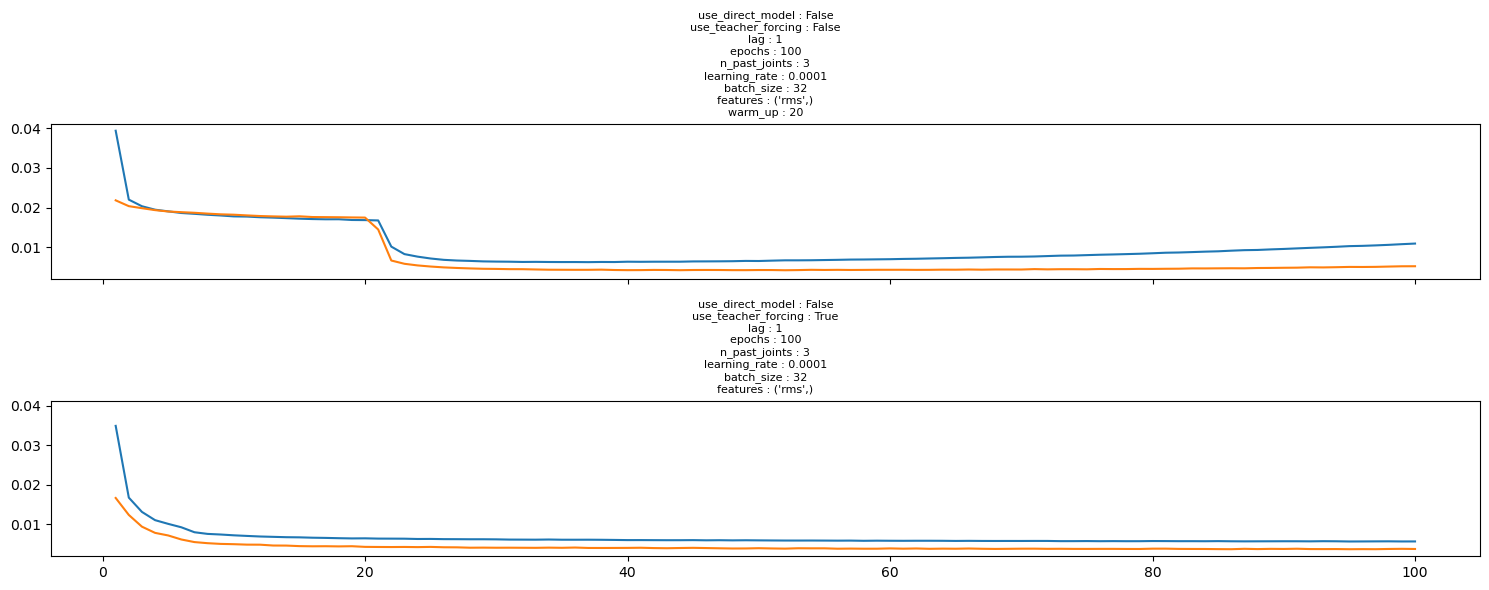

In [49]:
plot_history("narx")
plt.tight_layout()

In [82]:
from collections import deque, namedtuple

NarxResults = namedtuple("NarxResults", ("params", "targets", "teacher_pred", "schd_sampling_preds"))

def predict_narx(parent_dir): 
    parent_path = os.path.join("models", SUBJECT, parent_dir)
    results: list[NarxResults] = []
    for name in os.listdir(parent_path):
        if name.startswith(".") or not os.path.isdir(os.path.join(parent_path, name)): 
            continue
        args = get_params(parent_path, name)
        targets, emg_data = prepare_data(test_data, 10, 1, 222 * args["lag"], 5)
        if args["use_direct_model"]: 
            emg_data = emg_filter_downsample(emg_data, args["filter_time"], args["downsample_factor"])
        else: 
            emg_data = get_feature_vector(emg_data, *args["features"], lag=args["lag"])

        # prepare data for narx model and scale inputs (emg, past_joints)
        emg_data, targets, past_joints = zip(*[prepare_data_narx(args["n_past_joints"], emg, tar) for emg, tar in zip(emg_data, targets)])
        
        _, scale_joints, *emg_scale = read_norm_vals(os.path.join(parent_path, name))
        mu, sigma = np.array(emg_scale[0], dtype=float), np.array(emg_scale[1], dtype=float)
        scale_joints = {key: float(val) for scale in scale_joints for key, val in [scale.split(":")]}
        emg_data = [(emg - mu) / sigma for emg in emg_data]
        past_joints = [(pj - scale_joints["min_joints"]) / (scale_joints["max_joints"] - scale_joints["min_joints"]) for pj in past_joints]

        # predict - unrealistic teacher forcing way
        model = load_model(os.path.join(os.path.join(parent_path, name), "best_model.keras"), custom_objects={"LeakyReLU": LeakyReLU})
        teach_preds = [model.predict([in_emg, in_past_joints], verbose=False) for in_emg, in_past_joints in zip(emg_data, past_joints)]
        teach_preds = [pred * (scale_joints["max_joints"] - scale_joints["min_joints"]) + scale_joints["min_joints"] for pred in teach_preds]

        # predict - but this time the models is forced to make predictions based on previous predictions
        ss_preds = []
        for emg, pj in zip(emg_data, past_joints):
            cur_past_joints = deque(pj[0], maxlen=6)
            preds = []
            for i in range(len(emg)):
                # predict each time step 
                pred = model([emg[i:i+1], np.atleast_2d(cur_past_joints)])
                preds.append(pred[0])
                cur_past_joints += deque(list(*pred))
            preds = np.array(preds)
            preds = preds * (scale_joints["max_joints"] - scale_joints["min_joints"]) + scale_joints["min_joints"]
            ss_preds.append(preds)
        results.append(NarxResults(args, targets, teach_preds, ss_preds))
    return results

                
narx_predictions = predict_narx("narx")

In [90]:
def print_narx_metrics(m_pred): 
    res = []
    for pred in m_pred: 
        df_line = pred.params
        targets = np.vstack(pred.targets)
        teacher_pred = np.vstack(pred.teacher_pred)
        ss_pred = np.vstack(pred.schd_sampling_preds)
        df_line["r2_teacher_flex"] = r2_score(targets[:, 0], teacher_pred[:, 0])
        df_line["r2_teacher_pron"] = r2_score(targets[:, 1], teacher_pred[:, 1])
        df_line["r2_teacher"] = r2_score(targets, teacher_pred)

        df_line["r2_ss_flex"] = r2_score(targets[:, 0], ss_pred[:, 0])
        df_line["r2_ss_pron"] = r2_score(targets[:, 1], ss_pred[:, 1])
        df_line["r2_ss"] = r2_score(targets, ss_pred)
        res.append(df_line)
    return pd.DataFrame(res)

print_narx_metrics(narx_predictions)

,use_direct_model,use_teacher_forcing,lag,epochs,n_past_joints,learning_rate,batch_size,features,warm_up,r2_teacher_flex,r2_teacher_pron,r2_teacher,r2_ss_flex,r2_ss_pron,r2_ss
0,False,False,1,100,3,0.0001,32,"(rms,)",20.0,0.843114,0.908369,0.875742,0.743521,0.342268,0.542894
1,False,True,1,100,3,0.0001,32,"(rms,)",NaN,0.831869,0.959649,0.895759,0.624238,-0.417640,0.103296


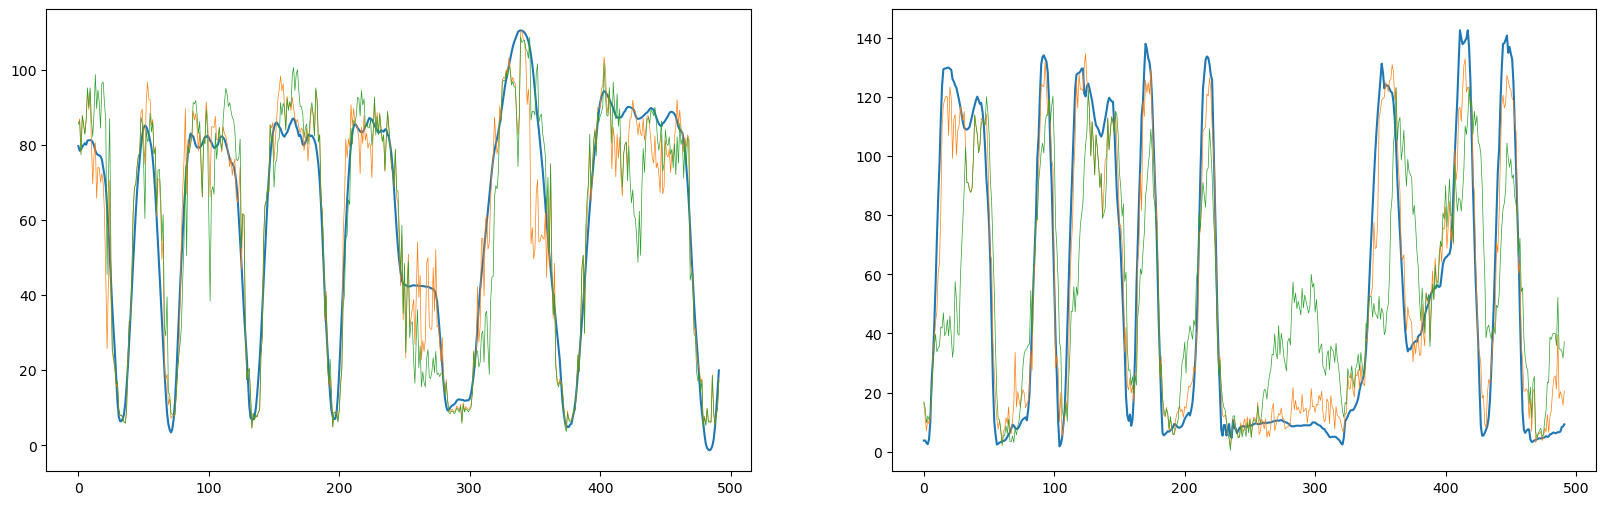

In [112]:
model_idx = 0
trail_idx = 1
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs[0].plot(narx_predictions[model_idx].targets[trail_idx][:, 0])
axs[0].plot(narx_predictions[model_idx].teacher_pred[trail_idx][:, 0], lw=0.5)
axs[0].plot(narx_predictions[model_idx].schd_sampling_preds[trail_idx][:, 0], lw=0.5)

axs[1].plot(narx_predictions[model_idx].targets[trail_idx][:, 1])
axs[1].plot(narx_predictions[model_idx].teacher_pred[trail_idx][:, 1], lw=0.5)
axs[1].plot(narx_predictions[model_idx].schd_sampling_preds[trail_idx][:, 1], lw=0.5)